In [1]:
import numpy as np
import pandas as pd

from matplotlib import pyplot as plt
import seaborn as sns

import os
from glob import glob
import re
import mygene
from tqdm.notebook import tqdm
from copy import deepcopy

In [2]:
def mylog(df):
    return np.log2(df + 1.0)

# save structure
def save_structure(ultradf, path='test.json'):
    ultrasave = deepcopy(ultradf)
    for e in ultrasave.keys():
        ultrasave[e]['data'] = ultrasave[e]['data'].reset_index().to_csv()
        ultrasave[e]['pheno'] = ultrasave[e]['pheno'].to_csv()
    with open(path, 'w+') as f:
        json.dump(ultrasave, f)
        
# save structure
def load_structure(path='ultradf.json'):
    import sys
    if sys.version_info[0] < 3: 
        from StringIO import StringIO #convert string to IO monade
    else:
        from io import StringIO
    #load after all
    with open(path, 'r') as f:
        ultradf = json.load(f)
        
    for e in ultradf.keys():
        ultradf[e]['data'] = pd.read_csv(StringIO(ultradf[e]['data']), index_col=0).set_index('index')
        ultradf[e]['pheno'] = pd.read_csv(StringIO(ultradf[e]['pheno']), index_col=0)
    
    return ultradf
        
        
def key2ENTREZ(df, key, species='mouse'):
    df = df.copy()
    raw = df.index.tolist()
    mg = mygene.MyGeneInfo()
    query = mg.querymany(raw, scopes=key, species=species, verbose=False)   

    ref2entrez = {r:[] for r in raw}
    for r, q in zip(raw, query):
        if 'entrezgene' in q:
            ref2entrez[r].append(q['entrezgene'])
        else:
            ref2entrez[r] = None

    print('Max number of ENTREZ across keys:', 
          max([len(ref2entrez[r]) for r in ref2entrez.keys() if ref2entrez[r] is not None]))

    ref2entrez = {k:v[0] for k,v in ref2entrez.items() if (v is not None) and (len(v)==1)}
    df.index = df.index.map(ref2entrez, na_action=None)
    df = df[~df.index.isna()]
    return df

def log_aggregation(df, method='mean'):
    tmp = (2**df.copy())
    if method=='mean':
        tmp = tmp.groupby(tmp.index).agg('mean')
    elif method=='sum':
        tmp = tmp.groupby(tmp.index).agg('sum')
    tmp = np.log2(tmp.copy())
    return tmp

def scale(df):
    tmp = df.copy()
    tmp = (tmp - tmp.mean()) / tmp.std()
    return tmp

def quantile_normalize(df):
    """
    input: dataframe with numerical columns
    output: dataframe with quantile normalized values
    """
    df = df.copy()
    df_sorted = pd.DataFrame(np.sort(df.values,
                                     axis=0), 
                             index=df.index, 
                             columns=df.columns)
    df_mean = df_sorted.mean(axis=1)
    df_mean.index = np.arange(1, len(df_mean) + 1)
    df_qn = df.rank(method="min").stack().astype(int).map(df_mean).unstack()
    return(df_qn)

# get data

In [3]:
U = load_structure('../Data/ultradf_v1.json')

In [4]:
key = list(U.keys())[0]
df, pheno, time = U[key]['data'], U[key]['pheno'], U[key]['time']

In [29]:
# from scipy.stats import linregress
# import statsmodels.api as sm

# regression analysis

In [5]:
from scipy.stats import linregress
from statsmodels.stats.multitest import multipletests as fdr_correction
from scipy.stats import spearmanr

def regression_analysis(data, time, fdr_thr=0.05):
    #make linear regression for each gene
    mean, std, intercept, slope, intercept_stderr, slope_stderr, p_value = [[] for i in range(7)]
    for g in tqdm(data.index):
        raw = data.loc[g]
        y = raw.values
        
        res = linregress(time, y) #<--- regression here
        
        #fill containers with metrics
        mean.append(np.mean(y))
        std.append(np.std(y, ddof=1)) 
        intercept.append(res.intercept) 
        slope.append(res.slope) 
        intercept_stderr.append(res.intercept_stderr) 
        slope_stderr.append(res.stderr) 
        p_value.append(res.pvalue)
        
    #create a result dataframe
    res_df = pd.DataFrame({'mean':mean, 
                           'std':std,
                           'intercept':intercept,
                           'slope':slope,
                           'intercept_stderr':intercept_stderr,
                           'slope_stderr':slope_stderr,
                           #'F_stat':[],
                           'p_value':p_value,
                           }, index= data.index)

    #Multiple testing correction
    passed, p_adj, _, _ = fdr_correction(res_df['p_value'], alpha=fdr_thr, method='fdr_bh')
    res_df['Passed'] = passed
    res_df['p_adj'] = p_adj
    return res_df

In [6]:
#conduct regression analysis for all datasets
for k in U.keys():
    print('Process %s' % k)
    df = U[k]['data']
    time = U[k]['time']
    U[k]['analysis'] = regression_analysis(df, time)

Process GSE67462$OSKM



Process GSE38509$OSKM



Process GSE38509$OSK



Process GSE38509$GFP



Process GSE116309$OKMS



Process GSE116309$OK+9MS



Process GSE46321$C/EBPα+ OSKM



Process GSE46321$C/EBPα- OSKM



Process GSE10871$OSKM



Process GSE21757$OKMS



Process GSE103979$Oct4+SK



Process GSE103979$Oct6+SK



Process GSE103979$Oct4+defSox+K



Process GSE103979$GFP


In [404]:
from scipy.stats import pearsonr
from scipy.stats import spearmanr

In [405]:
#{k:U[k]['analysis'][['slope', 'slope_stderr', 'p_value', 'p_adj']] for k in U.keys()}

#This function builds paired correlation matrix of logFC values
#for the specified number of top significant genes from matrices

def calculate_paired_correlation(U, top_genes=False, corr_method='spearman'):
    """ 
    U - container with data;
    """
    #gather data from the container to matrices of the same factor
    slope_matrix = pd.DataFrame({k:U[k]['analysis']['slope'] for k in U.keys()})
    pval_matrix = pd.DataFrame({k:U[k]['analysis']['p_value'] for k in U.keys()})

    cols = slope_matrix.columns
    N = slope_matrix.shape[1] #number of columns
    corr_dict = {'corr':np.eye(N),
                 'pval':np.eye(N),
                 'FDR':np.eye(N),
                 }
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols[i+1:], start=i+1):
            slopes_pair = slope_matrix[[c1, c2]].dropna(0)
            pval_pair = pval_matrix.loc[slopes_pair.index, [c1, c2]]

            # extract top genes from each of two dataset -> union them -> slice this union from the original one
            if (top_genes!=False) | (top_genes!=0):
                top1 = pval_pair.iloc[:, 0].sort_values()[:top_genes].index
                top2 = pval_pair.iloc[:, 1].sort_values()[:top_genes].index
                top_union = top1.union(top2) 
                slopes_pair = slopes_pair.loc[top_union]

            if corr_method == 'spearman':
                coef, pval = spearmanr(slopes_pair)
            elif corr_method == 'pearson':
                coef, pval = pearsonr(slopes_pair)
            else:
                raise NotImplementedError

            pval = pval if pval!=0. else 1e-100 

            corr_dict['corr'][i,j] = corr_dict['corr'][j,i] = coef
            corr_dict['pval'][i,j] = corr_dict['pval'][j,i] = pval
            #corr_dict['Zscore'][i,j] = corr_dict['Zscore'][j,i] = -np.log10(pval) * np.sign(coef)
        
    #FDR correction of p-values
    triu_pvals = corr_dict['pval'][np.triu_indices(N, k=1)]
    _, p_adj, _, _ = fdr_correction(triu_pvals, method='fdr_bh')
    corr_dict['FDR'][np.triu_indices(N, k=1)] = p_adj
    corr_dict['FDR'] += corr_dict['FDR'].T
    np.fill_diagonal(corr_dict['FDR'], 1.0)
        
    #convert to DataFrame
    corr_dict['corr'] = pd.DataFrame(corr_dict['corr'], columns=cols, index=cols)
    corr_dict['pval'] = pd.DataFrame(corr_dict['pval'], columns=cols, index=cols)
    corr_dict['FDR'] = pd.DataFrame(corr_dict['FDR'], columns=cols, index=cols)
    return corr_dict




In [406]:
#This script runs loop for the best number of top genes
def find_best_top_genes(U, number_genes_vector, 
                        FDR_thr=0.05, corr_thr=0.1, corr_method='spearman', plot=True):
    """ 
    U - container with data;
    number_genes_vector::[Int] - 1d vector with different number of top genes
    """
    #compute correlation dict for all genes
    complete_cor_dict = calculate_paired_correlation(U, top_genes=False, corr_method=corr_method)

    N = complete_cor_dict['FDR'].shape[0] #number of datasets
    FDR, COEF, BOTH = [], [], []
    for m in tqdm(number_genes_vector, desc='Calculate correlation of top genes:'):
        corr_dict = calculate_paired_correlation(U, top_genes=m, corr_method=corr_method)

        FDR.append((corr_dict['FDR'] < FDR_thr).sum().sum()/2 - N)
        COEF.append((abs(corr_dict['corr']) > corr_thr).sum().sum()/2 - N)
        BOTH.append(((corr_dict['FDR'] < FDR_thr) & (abs(corr_dict['corr']) > corr_thr)).sum().sum()/2 - N)

    #compute correlation dict for best number of top genes
    best_top_number = number_genes_vector[np.argmax(BOTH)]
    print("Optimal number of top genes:", best_top_number)
    optimal_corr_dict = calculate_paired_correlation(U, top_genes=best_top_number, corr_method=corr_method)

    if plot:
        plt.figure(figsize=(10,7))
        plt.plot(number_genes_vector, FDR, label='P.adjust < %.2f' % FDR_thr, lw=1.5)
        plt.plot(number_genes_vector, COEF, label='Coeff > %.2f' % corr_thr, lw=1.5)
        plt.plot(number_genes_vector, BOTH, label='Both', lw=1.5)
        plt.axvline(best_top_number, color='grey', ls='--')
        plt.title('Top genes plot', fontsize=16)
        plt.ylabel('Number of significant correlations', fontsize=14)
        plt.xlabel('Number of top genes', fontsize=14)
        plt.legend(fontsize=14)
        plt.grid(alpha=0.3)
        plt.show()
        
    return complete_cor_dict, optimal_corr_dict, best_top_number


Optimal number of top genes: 350


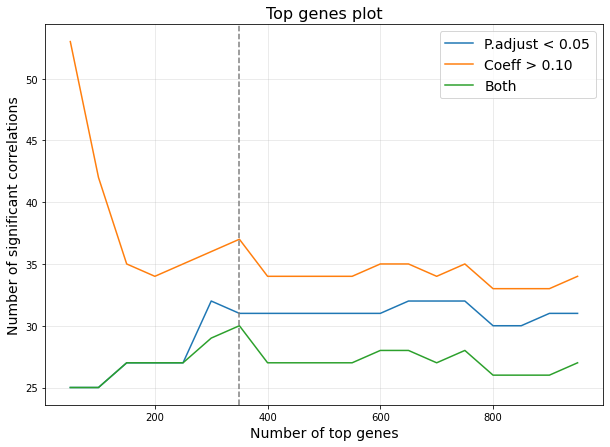

In [407]:
number_genes_vector = np.arange(50, 1000, 50)

complete_cor_dict, optimal_corr_dict, best_top_number = find_best_top_genes(U, number_genes_vector, 
                        FDR_thr=0.05, corr_thr=0.1, corr_method='spearman', plot=True)

In [408]:
from scipy.optimize import minimize
#This function returns sum of residuals over given normalization coefficients
def deming_sum(k_no_first):
    count = 0
    k = np.zeros(N)
    k[0] = 1
    k[1:] = k_no_first
    res = 0
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols[i+1:], start=i+1):
            common_genes = paired_genes[c1][c2]
            #if both FDR and Corr conditions were not satisfied - skip
            if corr_sign_matrix.loc[c1, c2] == 0.:
                continue
            ai = slope_matrix.loc[common_genes, c1]
            aj = slope_matrix.loc[common_genes, c2]
            assert ~ai.isna().any() or ~aj.isna().any(), 'NA in series'
            #if correlation is negative - reverse the sign for the correct
            #functional computation
            if corr_sign_matrix.loc[c1, c2] == -1.:
                aj = -1 * aj 

            res += sum(
              (((aj - (k[j]/k[i])*ai)**2)*((ai - (k[i]/k[j])*aj)**2))/ \
              (((aj - (k[j]/k[i])*ai)**2)+((ai - (k[i]/k[j])*aj)**2))) / len(common_genes)
            count += 1
    return res / count

#This functions performs multiple Deming regression using logFC matrix and parameters for filltering:
#number of genes, threshold for FDR and threshold for correlation coefficient
def deming_minimizer(U, optimal_corr_dict, top_genes, corr_thr=0.1, FDR_thr=0.05):
    #gather data from the container to matrices of the same factor
    slope_matrix = pd.DataFrame({k:U[k]['analysis']['slope'] for k in U.keys()})
    pval_matrix = pd.DataFrame({k:U[k]['analysis']['p_value'] for k in U.keys()})
    
    #add matrix of passed pairs of datasets according to criteria
    corr_sign_matrix = ((optimal_corr_dict['FDR'] < FDR_thr) \
                    & (abs(optimal_corr_dict['corr']) > corr_thr)) \
                    * np.sign(optimal_corr_dict['corr'])

    #fill container for common genes by two datasets keys
    cols = slope_matrix.columns
    N = slope_matrix.shape[1] #number of columns
    paired_genes = {c:{} for c in cols} 
    for i, c1 in enumerate(cols):
        for j, c2 in enumerate(cols[i+1:], start=i+1):
            slopes_pair = slope_matrix[[c1, c2]].dropna(0)
            pval_pair = pval_matrix.loc[slopes_pair.index, [c1, c2]]
            # extract top genes from each of two dataset -> 
            # union them -> slice this union from the original one
            if (top_genes!=False) | (top_genes!=0):
                top1 = pval_pair.iloc[:, 0].sort_values()[:top_genes].index
                top2 = pval_pair.iloc[:, 1].sort_values()[:top_genes].index
                top_union = top1.union(top2) 
                paired_genes[c1][c2] = top_union
            else:
                paired_genes[c1][c2] = slopes_pair.index

    #positive normally distributed initial coefficients
    kvec = np.abs(np.random.randn(N-1) * 1 + 1) 
    optimized = minimize(deming_sum, kvec, 
                         bounds=[(0.01, 100) for _ in range(N-1)], #low and up bounds for each coef
                         method="L-BFGS-B")
    #best found argument 
    kres = np.ones(N)
    kres[1:] = optimized.x
    obj = optimized.fun
    if optimized.success != True:
        print('Optimizer failed to converge with obj=%.3f at n_iteration=%d' % (obj, optimized.nit))        
    return kres, obj
        

In [440]:
#This script performs multiple Deming minimization and provides Deming output,
#best coefficients along with quality figures

def multiple_deming_normalization(U, optimal_corr_dict,
                                  top_genes=20, 
                                  coeff_thresholds=[0.1],
                                  FDR_thr=0.05,
                                  number_iter=2,
                                  plot=True):
    #create a container for output
    class deming_output: pass
    #gather data from the container to matrices of the same factor
    slope_matrix = pd.DataFrame({k:U[k]['analysis']['slope'] for k in U.keys()})
    pval_matrix = pd.DataFrame({k:U[k]['analysis']['p_value'] for k in U.keys()})
    se_matrix = pd.DataFrame({k:U[k]['analysis']['slope_stderr'] for k in U.keys()})

    def matrix_plot(matrix, ylim=(0, 3), title=None):
        matrix.plot(kind='kde')
        plt.ylim(ylim)
        plt.xlim((-3, 3))
        plt.legend(bbox_to_anchor=(1.02, 1), loc=2)
        plt.title(title)
        plt.show()

    #a) plot before normalization    
    if plot:
        matrix_plot(slope_matrix, (0, 5), 'Before normalization')   

    #b) Normalize by sd
    slope_matrix_sd = slope_matrix / slope_matrix.std()
    se_matrix_sd = se_matrix / slope_matrix.std()
    #plot after sd normalization
    if plot:
        matrix_plot(slope_matrix_sd, (0, 5), 'After sd normalization')   

    #c) Run Deming regression
    deming_results = {}
    for thr in coeff_thresholds:
        for it in range(number_iter):
            print("Start with correlation threshold = %.2f; iteration %d" % (thr, it))
            deming_results[(thr, it)] = deming_minimizer(U, optimal_corr_dict, top_genes, 
                                                         corr_thr=thr, FDR_thr=FDR_thr)

    df = pd.DataFrame()
    for (coef, it), (vec, obj) in deming_results.items():
        df = df.append(pd.DataFrame({
                        'dataset':slope_matrix.columns,
                        'coef':vec,
                        'iter':[it] * len(vec),
                        'thr':[coef] * len(vec),
                        'obj':[obj] * len(vec)
                        }))
        
    deming_output.results_dict = deming_results
    deming_output.df = df #write to output
    #d) Visualize coefficient consistency in boxplot format
    if plot:
        plt.figure(figsize=(12,8))
        sns.stripplot(x="dataset", y="coef", hue="thr",
                    data=df, jitter=True,
                    dodge=True, linewidth=1)
        plt.legend(bbox_to_anchor=(1.02, 1), loc=2, borderaxespad=0., 
                   title='Coef threshold')

        sns.boxplot(x="dataset", y="coef", #hue="obj",
                    data=df, fliersize=0, color='white')

        plt.yscale('log')
        plt.ylabel('log10(Coef)', fontsize=14)
        plt.xlabel('Signature', fontsize=14)
        plt.xticks(rotation=60)
        plt.grid(alpha=0.3)
        plt.show()

    (thr, it), (best_coefs, best_obj) = min(deming_results.items(), key=lambda x: x[1][1])
    #e) Normalize data
    slope_matrix_sd_norm = slope_matrix_sd / best_coefs
    se_matrix_sd_norm = se_matrix_sd / best_coefs
    if plot:
        matrix_plot(slope_matrix_sd_norm, (0, 5), 'After Deming normalization') 
    
    #fill outp
    deming_output.slope_norm = slope_matrix_sd_norm
    deming_output.se_norm = se_matrix_sd_norm
    deming_output.best_coefs = best_coefs
    deming_output.best_obj = best_obj
    return deming_output

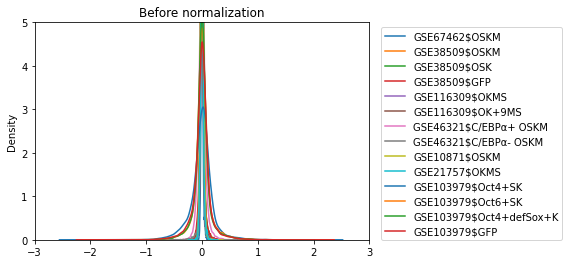

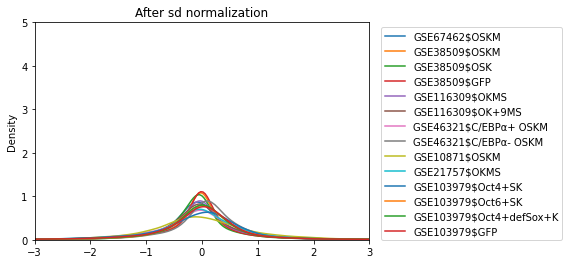

Start with correlation threshold = 0.10; iteration 0
Start with correlation threshold = 0.10; iteration 1
Start with correlation threshold = 0.10; iteration 2
Start with correlation threshold = 0.15; iteration 0
Start with correlation threshold = 0.15; iteration 1
Start with correlation threshold = 0.15; iteration 2
Start with correlation threshold = 0.20; iteration 0
Start with correlation threshold = 0.20; iteration 1
Start with correlation threshold = 0.20; iteration 2


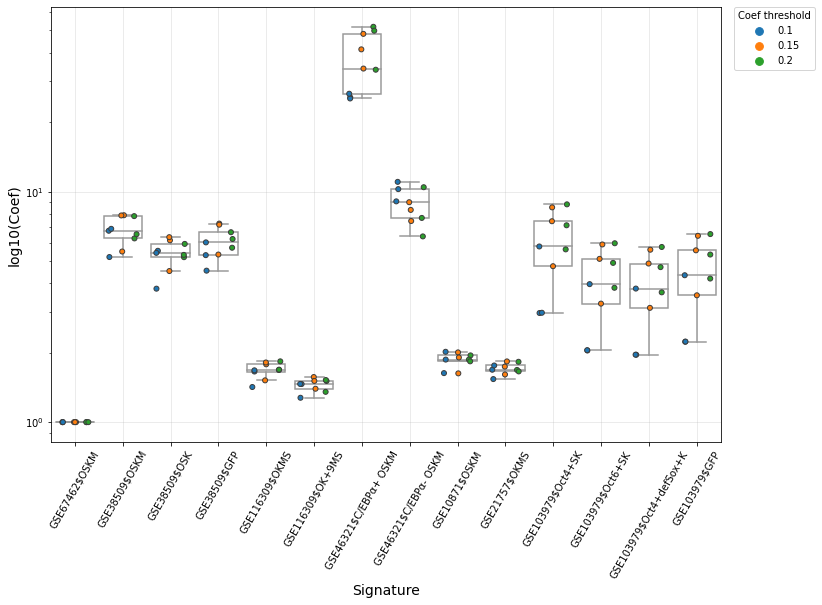

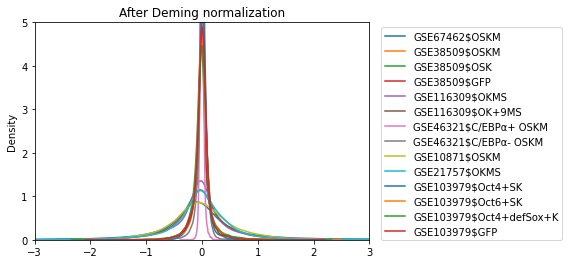

In [442]:
deming_output = multiple_deming_normalization(U, 
                                              optimal_corr_dict,
                                              top_genes=best_top_number, 
                                              coeff_thresholds=[0.1, 0.15, 0.2],
                                              FDR_thr=0.05,
                                              number_iter=3,
                                              plot=True)

In [452]:
##################################
#This functions performs statistical meta analysis with specified
#data matrix, descriptions and random terms
#For each gene the function construct INTERCEPTION-ONLY model and calculate
#corresponding statistic





In [566]:
deming_output.slope_norm

,GSE67462$OSKM,GSE38509$OSKM,GSE38509$OSK,GSE38509$GFP,GSE116309$OKMS,GSE116309$OK+9MS,GSE46321$C/EBPα+ OSKM,GSE46321$C/EBPα- OSKM,GSE10871$OSKM,GSE21757$OKMS,GSE103979$Oct4+SK,GSE103979$Oct6+SK,GSE103979$Oct4+defSox+K,GSE103979$GFP
index,,,,,,,,,,,,,,
11287,0.078555,-0.019189,-0.081676,0.022540,-0.219803,-0.061664,0.060963,0.022208,-0.817145,0.064635,NaN,NaN,NaN,NaN
11298,0.000752,0.012015,-0.013910,0.042151,-0.114215,-0.133474,-0.005878,0.073898,0.329260,-0.205832,NaN,NaN,NaN,NaN
11302,0.069726,0.043971,-0.035056,-0.006363,0.062746,-0.341459,-0.009773,-0.102756,0.084155,-0.146784,NaN,NaN,NaN,NaN
11303,0.967085,0.648707,0.786103,0.675351,-0.369697,-0.454708,0.032193,-0.069788,1.117565,1.124279,-0.066947,-0.020420,-0.083599,-0.064153
11304,0.050481,-0.071418,-0.037875,0.002246,0.029831,0.325073,-0.000271,0.005433,0.727688,-0.063719,0.024577,0.018821,0.049668,0.075770
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115490342,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.063594,0.067230,0.172436,0.152226
117903916,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.166344,0.138464,0.214236,0.194682
118567733,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.010520,0.030484,0.023976,0.034296


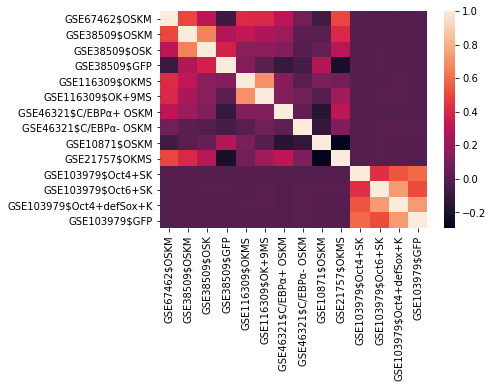

In [95]:
# sns.heatmap(complete_cor_dict['corr'])
# sns.heatmap(optimal_corr_dict['corr'])

In [299]:
U[list(U.keys())[0]]['analysis']

,mean,std,intercept,slope,intercept_stderr,slope_stderr,p_value,Passed,p_adj
index,,,,,,,,,
11287,-0.913865,0.028989,-0.920351,0.000865,0.011599,0.001195,0.481072,False,0.650289
11298,0.465746,0.044261,0.465683,0.000008,0.018038,0.001858,0.996506,False,0.997682
11302,1.618729,0.041838,1.612971,0.000768,0.016934,0.001744,0.666585,False,0.793293
11303,0.168545,0.114341,0.088691,0.010647,0.037527,0.003865,0.015508,False,0.056856
11304,-0.797408,0.033079,-0.801577,0.000556,0.013404,0.001381,0.693360,False,0.812039
...,...,...,...,...,...,...,...,...,...
102443351,-0.362053,0.037158,-0.360980,-0.000143,0.015139,0.001559,0.928249,False,0.959985
102640923,-1.612459,0.051288,-1.606001,-0.000861,0.020782,0.002141,0.693559,False,0.812180
105886298,0.001187,0.053540,0.011319,-0.001351,0.021536,0.002218,0.552274,False,0.707869


# meta analysis test


tutorial https://www.statsmodels.org/stable/examples/notebooks/generated/mixed_lm_example.html

## pig data

In [463]:
#mixed effects model

%matplotlib inline

import numpy as np
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.tools.sm_exceptions import ConvergenceWarning

In [466]:
data = sm.datasets.get_rdataset('dietox', 'geepack').data
data

,Pig,Evit,Cu,Litter,Start,Weight,Feed,Time
0,4601,Evit000,Cu000,1,26.5,26.50000,NaN,1
1,4601,Evit000,Cu000,1,26.5,27.59999,5.200005,2
2,4601,Evit000,Cu000,1,26.5,36.50000,17.600000,3
3,4601,Evit000,Cu000,1,26.5,40.29999,28.500000,4
4,4601,Evit000,Cu000,1,26.5,49.09998,45.200001,5
...,...,...,...,...,...,...,...,...
856,8442,Evit000,Cu175,24,25.7,73.19995,83.800003,8
857,8442,Evit000,Cu175,24,25.7,81.69995,99.800003,9
858,8442,Evit000,Cu175,24,25.7,90.29999,115.200001,10
859,8442,Evit000,Cu175,24,25.7,96.00000,133.200001,11


In [464]:
#Pig Group Id as random intercept
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"])
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Weight    
No. Observations: 861     Method:             REML      
No. Groups:       72      Scale:              11.3669   
Min. group size:  11      Log-Likelihood:     -2404.7753
Max. group size:  12      Converged:          Yes       
Mean group size:  12.0                                  
--------------------------------------------------------
             Coef.  Std.Err.    z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept    15.724    0.788  19.952 0.000 14.179 17.268
Time          6.943    0.033 207.939 0.000  6.877  7.008
Group Var    40.395    2.149                            



In [481]:
sum([v.item() for _, v in mdf.random_effects.items()]) #random intercepts sum to zero

-1.818223349658865e-11

Next we fit a model with two random effects for each animal: a random intercept, and a random slope (with respect to time). This means that each pig may have a different baseline weight, as well as growing at a different rate. The formula specifies that “Time” is a covariate with a random coefficient. By default, formulas always include an intercept (which could be suppressed here using “0 + Time” as the formula

In [487]:
#Pig Group Id as random intercept + slope over time
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"], re_formula='~Time')
mdf = md.fit(method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Weight    
No. Observations:  861      Method:              REML      
No. Groups:        72       Scale:               6.0372    
Min. group size:   11       Log-Likelihood:      -2217.0475
Max. group size:   12       Converged:           Yes       
Mean group size:   12.0                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        15.739    0.550 28.603 0.000 14.660 16.817
Time              6.939    0.080 86.925 0.000  6.783  7.095
Group Var        19.503    1.561                           
Group x Time Cov  0.294    0.153                           
Time Var          0.416    0.033                           



The random intercept and random slope are only weakly correlated. So next we fit a model in which the two random effects are constrained to be uncorrelated:

In [488]:
md = smf.mixedlm("Weight ~ Time", data, groups=data["Pig"],
                  re_formula="~Time")
free = sm.regression.mixed_linear_model.MixedLMParams.from_components(np.ones(2),
                                                                      np.eye(2))

mdf = md.fit(free=free, method=["lbfgs"])
print(mdf.summary())

           Mixed Linear Model Regression Results
Model:             MixedLM  Dependent Variable:  Weight    
No. Observations:  861      Method:              REML      
No. Groups:        72       Scale:               6.0283    
Min. group size:   11       Log-Likelihood:      -2217.3481
Max. group size:   12       Converged:           Yes       
Mean group size:   12.0                                    
-----------------------------------------------------------
                 Coef.  Std.Err.   z    P>|z| [0.025 0.975]
-----------------------------------------------------------
Intercept        15.739    0.554 28.388 0.000 14.652 16.825
Time              6.939    0.080 86.248 0.000  6.781  7.097
Group Var        19.837    1.571                           
Group x Time Cov  0.000    0.000                           
Time Var          0.423    0.033                           



## Sitka data

The outcome variable is the size of the tree, and the covariate used here is a time value. The data are grouped by tree.

In [490]:
data = sm.datasets.get_rdataset("Sitka", "MASS").data
data

,size,Time,tree,treat
0,4.51,152,1,ozone
1,4.98,174,1,ozone
2,5.41,201,1,ozone
3,5.90,227,1,ozone
4,6.15,258,1,ozone
...,...,...,...,...
390,2.99,152,79,control
391,3.61,174,79,control
392,4.48,201,79,control
393,4.91,227,79,control


In [491]:
endog = data["size"]
data["Intercept"] = 1
exog = data[["Intercept", "Time"]]

Here is the statsmodels LME fit for a basic model with a random intercept. We are passing the endog and exog data directly to the LME init function as arrays. Also note that endog_re is specified explicitly in argument 4 as a random intercept (although this would also be the default if it were not specified)

In [495]:
md = sm.MixedLM(endog, exog, groups=data["tree"], exog_re=exog["Intercept"])
mdf = md.fit()
print(mdf.summary())

         Mixed Linear Model Regression Results
Model:             MixedLM Dependent Variable: size    
No. Observations:  395     Method:             REML    
No. Groups:        79      Scale:              0.0392  
Min. group size:   5       Log-Likelihood:     -82.3884
Max. group size:   5       Converged:          Yes     
Mean group size:   5.0                                 
-------------------------------------------------------
              Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------
Intercept     2.273    0.088 25.864 0.000  2.101  2.446
Time          0.013    0.000 47.796 0.000  0.012  0.013
Intercept Var 0.374    0.345                           



In [496]:
exog_re = exog.copy()
md = sm.MixedLM(endog, exog, data["tree"], exog_re)
mdf = md.fit()
print(mdf.summary())

             Mixed Linear Model Regression Results
Model:               MixedLM    Dependent Variable:    size    
No. Observations:    395        Method:                REML    
No. Groups:          79         Scale:                 0.0264  
Min. group size:     5          Log-Likelihood:        -62.4834
Max. group size:     5          Converged:             Yes     
Mean group size:     5.0                                       
---------------------------------------------------------------
                     Coef.  Std.Err.   z    P>|z| [0.025 0.975]
---------------------------------------------------------------
Intercept             2.273    0.101 22.513 0.000  2.075  2.471
Time                  0.013    0.000 33.888 0.000  0.012  0.013
Intercept Var         0.646    0.914                           
Intercept x Time Cov -0.001    0.003                           
Time Var              0.000    0.000                           



/home/shappiron/anaconda3/lib/python3.7/site-packages/statsmodels/regression/mixed_linear_model.py:2237: ConvergenceWarning: The MLE may be on the boundary of the parameter space.
  warnings.warn(msg, ConvergenceWarning)


We can further explore the random effects structure by constructing plots of the profile likelihoods. We start with the random intercept, generating a plot of the profile likelihood from 0.1 units below to 0.1 units above the MLE. Since each optimization inside the profile likelihood generates a warning (due to the random slope variance being close to zero), we turn off the warnings here.

In [497]:
import warnings

with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    likev = mdf.profile_re(0, 're', dist_low=0.1, dist_high=0.1)

In [502]:
# plt.figure(figsize=(10,8))
# plt.plot(likev[:,0], 2*likev[:,1])
# plt.xlabel("Variance of random slope", size=17)
# plt.ylabel("-2 times profile log likelihood", size=17)
# plt.grid(alpha=0.4);

Here is a plot of the profile likelihood function. The profile likelihood plot shows that the MLE of the random slope variance parameter is a very small positive number, and that there is low uncertainty in this estimate.

In [501]:
# re = mdf.cov_re.iloc[1, 1]
# with warnings.catch_warnings():
#     # Parameter is often on the boundary
#     warnings.simplefilter("ignore", ConvergenceWarning)
#     likev = mdf.profile_re(1, 're', dist_low=.5*re, dist_high=0.8*re)

# plt.figure(figsize=(10, 8))
# plt.plot(likev[:,0], 2*likev[:,1])
# plt.xlabel("Variance of random slope", size=17)
# lbl = plt.ylabel("-2 times profile log likelihood", size=17)

## Intercept-only model

In [596]:
data = sm.datasets.get_rdataset("Sitka", "MASS").data
data = data[data.tree < 5]

In [645]:
endog = data["size"]
data["Intercept"] = 1
data["stderr"] = 0.1
data["id"] = data.index
exog = data[["Intercept"]]

In [598]:
from statsmodels.regression.mixed_linear_model import VCSpec

In [594]:
#VCSpec(['stderr'], [])
# free = sm.regression.mixed_linear_model.MixedLMParams.from_components(
#         vcomp=np.array(data[["stderr"]]).ravel())

In [602]:
data

,size,Time,tree,treat,Intercept,stderr,id
0,4.51,152,1,ozone,1,0.1,0
1,4.98,174,1,ozone,1,0.1,1
2,5.41,201,1,ozone,1,0.1,2
3,5.90,227,1,ozone,1,0.1,3
4,6.15,258,1,ozone,1,0.1,4
5,4.24,152,2,ozone,1,0.1,5
6,4.20,174,2,ozone,1,0.1,6
7,4.68,201,2,ozone,1,0.1,7
8,4.92,227,2,ozone,1,0.1,8
9,4.96,258,2,ozone,1,0.1,9


In [658]:
vc = VCSpec(names=['stderr'], 
            colnames=[np.array(data['id'])], 
            mats=[data['stderr'][None, :]])

/home/shappiron/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: FutureWarning: Support for multi-dimensional indexing (e.g. `obj[:, None]`) is deprecated and will be removed in a future version.  Convert to a numpy array before indexing instead.
  This is separate from the ipykernel package so we can avoid doing imports until


**нужно сравнить запараметризованную дисперсию с rma.mv на dummy датасете**

In [662]:
vc.mats[0].shape

(1, 20)

In [660]:
md = sm.MixedLM(endog, exog, groups=data["id"], 
                exog_re=exog["Intercept"], exog_vc=vc)
mdf = md.fit()
print(mdf.summary())

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 2 dimension(s) and the array at index 1 has 1 dimension(s)

In [526]:
global_int = mdf.params['Intercept']
global_int_se = np.sqrt(mdf.cov_params().loc['Intercept', 'Intercept'])

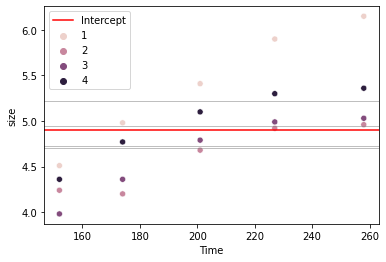

In [564]:
ax = sns.scatterplot(x='Time', y='size', data=sub, hue="tree")
plt.axhline(global_int, label='Intercept', color='red', lw=1.5)
for _,v in mdf.random_effects.items():
    plt.axhline(v['Intercept'] + global_int, color='grey', lw=0.5)

plt.legend();

## Variance component analysis

In [631]:
import numpy as np
import statsmodels.api as sm
from statsmodels.regression.mixed_linear_model import VCSpec
import pandas as pd

np.random.seed(3123)

In [632]:
def generate_nested(n_group1=200, n_group2=20, n_rep=10, group1_sd=2,
                    group2_sd=3, unexplained_sd=4):

    # Group 1 indicators
    group1 = np.kron(np.arange(n_group1), np.ones(n_group2 * n_rep))

    # Group 1 effects
    u = group1_sd * np.random.normal(size=n_group1)
    effects1 = np.kron(u, np.ones(n_group2 * n_rep))

    # Group 2 indicators
    group2 = np.kron(np.ones(n_group1), np.kron(np.arange(n_group2), np.ones(n_rep)))

    # Group 2 effects
    u = group2_sd * np.random.normal(size=n_group1*n_group2)
    effects2 = np.kron(u, np.ones(n_rep))

    e = unexplained_sd * np.random.normal(size=n_group1 * n_group2 * n_rep)
    y = effects1 + effects2 + e

    df = pd.DataFrame({"y":y, "group1": group1, "group2": group2})

    return df

In [633]:
df = generate_nested()

In [634]:
df

,y,group1,group2
0,-2.193553,0.0,0.0
1,-1.996399,0.0,0.0
2,-7.268743,0.0,0.0
3,-4.701142,0.0,0.0
4,3.464830,0.0,0.0
...,...,...,...
39995,-1.709221,199.0,19.0
39996,10.295354,199.0,19.0
39997,1.312228,199.0,19.0
39998,-0.339235,199.0,19.0


In [635]:
model1 = sm.MixedLM.from_formula("y ~ 1", re_formula="1", vc_formula={"group2": "0 + C(group2)"},
                groups="group1", data=df)
result1 = model1.fit()
print(result1.summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y           
No. Observations: 40000   Method:             REML        
No. Groups:       200     Scale:              15.8825     
Min. group size:  200     Log-Likelihood:     -116022.3805
Max. group size:  200     Converged:          Yes         
Mean group size:  200.0                                   
-----------------------------------------------------------
            Coef.   Std.Err.    z     P>|z|  [0.025  0.975]
-----------------------------------------------------------
Intercept   -0.035     0.149  -0.232  0.817  -0.326   0.257
group1 Var   3.917     0.112                               
group2 Var   8.742     0.063                               



In [636]:
def f(x):
    n = x.shape[0]
    g2 = x.group2
    u = g2.unique()
    u.sort()
    uv = {v: k for k, v in enumerate(u)}
    mat = np.zeros((n, len(u)))
    for i in range(n):
        mat[i, uv[g2.iloc[i]]] = 1
    colnames = ["%d" % z for z in u]
    return mat, colnames

In [637]:
vcm = df.groupby("group1").apply(f).to_list()
mats = [x[0] for x in vcm]
colnames = [x[1] for x in vcm]
names = ["group2"]
vcs = VCSpec(names, [colnames], [mats])

In [640]:
oo = np.ones(df.shape[0])
model2 = sm.MixedLM(df.y, oo, exog_re=oo, groups=df.group1, exog_vc=vcs)
result2 = model2.fit()
print(result2.summary())

(200, 20)